In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from transformers import TFBertForSequenceClassification
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,roc_auc_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/tamil_sentiment")

In [ ]:
df

,tamil_cleaned,label
0,வானி போஜன் ரசிகர்கள் சோலியைப் போல வாங்கிடா வெண...,1
1,நான் உன்னை விரும்புகிறேன் அஜித் நான் விரும்புக...,0
2,என்னாயா டிரெய்லர் கு முடி எல்லம் வேரா நிலை,0
3,விஜய் அண்ணா உர் மாஸ் தெர்ரி,0
4,நம்ப நடே நாசாமா,2
...,...,...
37700,,1
37701,நாடக காதல்இதை தான் இந்தவெள்ளாள பிள்ளைமார் சார்...,0
37702,சூப்பர் எஸ்கே,3
37703,குறைந்தபட்ச எம் வியா வரா வெப்போமா அனைத்து தாலா...,0


In [ ]:
df.dtypes

tamil_cleaned    object
label             int64
dtype: object

In [ ]:
df.shape

(37705, 2)

In [ ]:
train,test= train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
max_length = 512
batch_size = 6

# Instantiate the tokenizer
model_name = 'bert-base-multilingual-uncased'  # You may need a multilingual model for Tamil
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [ ]:
# Assuming you have four labels: 0, 1, 2, 3
num_labels = 4

def convert_example_to_feature(sentiment):
    return tokenizer.encode_plus(sentiment,
                                 add_special_tokens=True,
                                 max_length=max_length,
                                 padding='max_length',
                                 return_attention_mask=True,
                                 truncation=True
                                 )

In [ ]:
def map_example_to_dict(row):
    bert_input = convert_example_to_feature(row['tamil_cleaned'])
    return {
        "input_ids": bert_input['input_ids'],
        "token_type_ids": bert_input['token_type_ids'],
        "attention_mask": bert_input['attention_mask'],
    }, tf.keras.utils.to_categorical(row['label'], num_classes=num_labels)

In [ ]:
def encode_examples(df, limit=-1):
    if limit > 0:
        df = df.head(limit)

    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []

    for _, row in df.iterrows():
        example_dict, label = map_example_to_dict(row)
        input_ids_list.append(example_dict['input_ids'])
        token_type_ids_list.append(example_dict['token_type_ids'])
        attention_mask_list.append(example_dict['attention_mask'])
        label_list.append(label)

    return (
        tf.convert_to_tensor(input_ids_list),
        tf.convert_to_tensor(token_type_ids_list),
        tf.convert_to_tensor(attention_mask_list),
        tf.convert_to_tensor(label_list)
    )

In [ ]:
# Encode the dataset
train_dataset = encode_examples(train)
test_dataset = encode_examples(test)

In [ ]:
# Check the train shapes
print("Input IDs shape:", train_dataset[0].shape)
print("Token Type IDs shape:", train_dataset[1].shape)
print("Attention Mask shape:", train_dataset[2].shape)
print("Labels shape:", train_dataset[3].shape)

Input IDs shape: (30164, 512)
Token Type IDs shape: (30164, 512)
Attention Mask shape: (30164, 512)
Labels shape: (30164, 4)


In [ ]:

# Check the test shapes
print("Input IDs shape:", test_dataset[0].shape)
print("Token Type IDs shape:", test_dataset[1].shape)
print("Attention Mask shape:", test_dataset[2].shape)
print("Labels shape:", test_dataset[3].shape)

Input IDs shape: (7541, 512)
Token Type IDs shape: (7541, 512)
Attention Mask shape: (7541, 512)
Labels shape: (7541, 4)


In [ ]:
# Assuming you have 4 classes in your dataset
num_classes = 4

# Model initialization
model_name = 'bert-base-multilingual-uncased'  # Replace with your desired model
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# Choosing Adam optimizer
learning_rate = 2e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Loss function: Categorical Crossentropy
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# Assuming you have the train_dataset from the previous code
input_ids, token_type_ids, attention_mask, labels = train_dataset

input_ids = input_ids[:]
token_type_ids = token_type_ids[:]
attention_mask = attention_mask[:]
labels = labels[:]

In [ ]:
# Assuming you have the test_dataset from the previous code
val_input_ids, val_token_type_ids, val_attention_mask, val_labels = test_dataset

val_input_ids = val_input_ids[:]
val_token_type_ids = val_token_type_ids[:]
val_attention_mask = val_attention_mask[:]
val_labels = val_labels[:]

In [ ]:
checkpoint_path = "bert_training_checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=2
)

In [ ]:
# Train the model
history = model.fit(
    x={'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask},
    y=labels,
    epochs=4,
    batch_size=batch_size,
    validation_data=(
        {'input_ids': val_input_ids, 'token_type_ids': val_token_type_ids, 'attention_mask': val_attention_mask},
        val_labels.numpy()
    ),callbacks=[checkpoint_callback]
)

Epoch 1/4
5028/5028 [==============================] - ETA: 0s - loss: 1.0303 - accuracy: 0.5979
Epoch 1: val_loss improved from inf to 0.96868, saving model to bert_training_checkpoint.ckpt
5028/5028 [==============================] - 4046s 793ms/step - loss: 1.0303 - accuracy: 0.5979 - val_loss: 0.9687 - val_accuracy: 0.6193
Epoch 2/4
5028/5028 [==============================] - ETA: 0s - loss: 0.9534 - accuracy: 0.6214
Epoch 2: val_loss improved from 0.96868 to 0.94470, saving model to bert_training_checkpoint.ckpt
5028/5028 [==============================] - 3980s 792ms/step - loss: 0.9534 - accuracy: 0.6214 - val_loss: 0.9447 - val_accuracy: 0.6276
Epoch 3/4
5028/5028 [==============================] - ETA: 0s - loss: 0.8949 - accuracy: 0.6493
Epoch 3: val_loss did not improve from 0.94470
5028/5028 [==============================] - 4027s 801ms/step - loss: 0.8949 - accuracy: 0.6493 - val_loss: 0.9473 - val_accuracy: 0.6374
Epoch 4/4
5028/5028 [==============================] - E

In [ ]:
train_loss_history=[]
train_accuracy_history=[]
val_loss_history=[]
val_accuracy_history=[]

In [ ]:
# Store metrics in lists
train_loss_history.extend(history.history['loss'])
train_accuracy_history.extend(history.history['accuracy'])
val_loss_history.extend(history.history['val_loss'])
val_accuracy_history.extend(history.history['val_accuracy'])

In [ ]:
print("train_loss_history : ",train_loss_history)
print("train_accuracy_history : ",train_accuracy_history)
print("val_loss_history : ",val_loss_history)
print("val_accuracy_history : ",val_accuracy_history)

train_loss_history :  [1.0303319692611694, 0.9533922076225281, 0.8949195146560669, 0.8296893835067749]
train_accuracy_history :  [0.5978649854660034, 0.6214361786842346, 0.6492507457733154, 0.6773637533187866]
val_loss_history :  [0.9686756730079651, 0.9446980953216553, 0.9472882151603699, 0.9602656960487366]
val_accuracy_history :  [0.6192812919616699, 0.6276355981826782, 0.6374486088752747, 0.630287766456604]


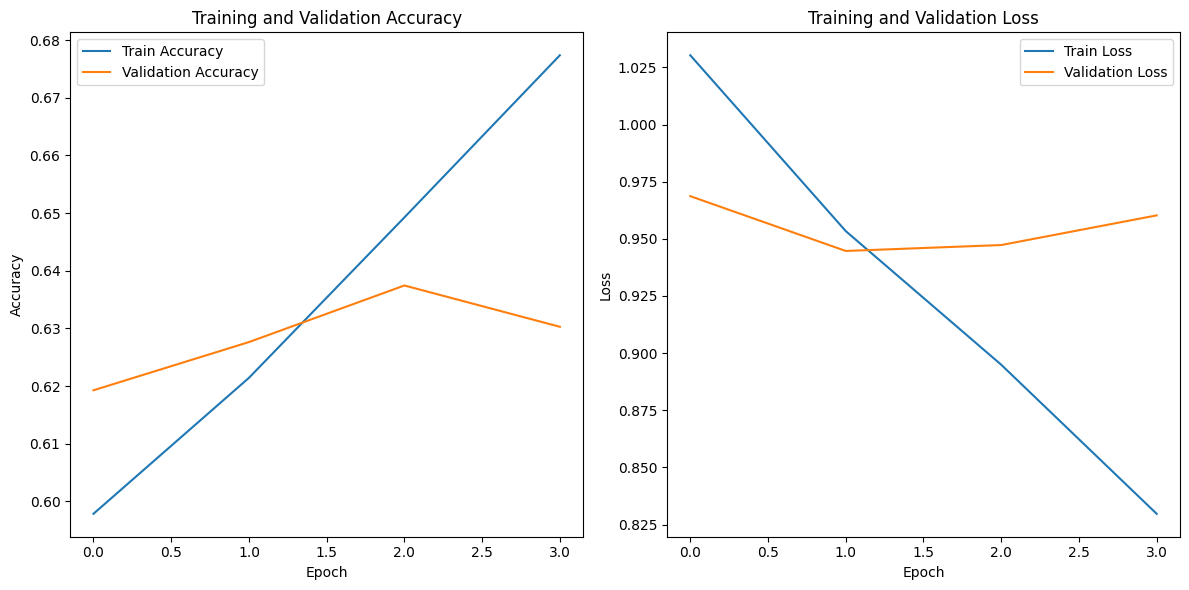

In [ ]:
#Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(
    x={'input_ids': val_input_ids, 'token_type_ids': val_token_type_ids, 'attention_mask': val_attention_mask}
)

236/236 [==============================] - 317s 1s/step


In [ ]:
# Convert predictions to labels
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convert one-hot encoded true labels to categorical labels
true_labels = np.argmax(val_labels.numpy(), axis=1)

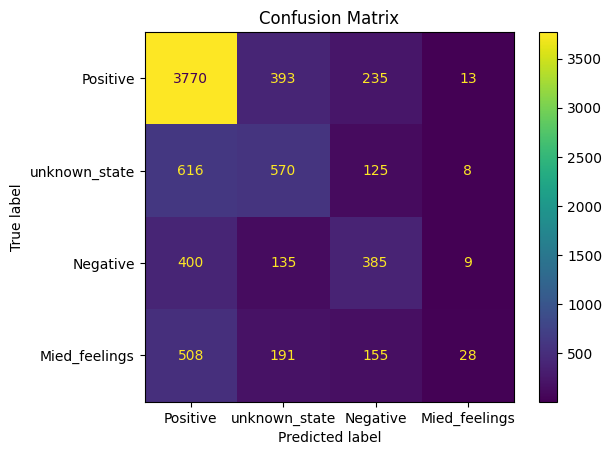

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Positive','unknown_state','Negative','Mied_feelings'])
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['Positive','unknown_state','Negative','Mied_feelings'])
print(class_report)

               precision    recall  f1-score   support

     Positive       0.71      0.85      0.78      4411
unknown_state       0.44      0.43      0.44      1319
     Negative       0.43      0.41      0.42       929
Mied_feelings       0.48      0.03      0.06       882

     accuracy                           0.63      7541
    macro avg       0.52      0.43      0.42      7541
 weighted avg       0.60      0.63      0.59      7541



In [ ]:
# Assuming predicted_labels and true_labels are NumPy arrays
data = {'Predicted_Labels': predicted_labels, 'True_Labels': true_labels}
try1 = pd.DataFrame(data)

# Save DataFrame to a CSV file
try1.to_csv('/content/drive/MyDrive/predicted_vs_true_labels1.csv', index=False)

In [ ]:
try1=pd.read_csv("/content/drive/MyDrive/predicted_vs_true_labels1.csv")

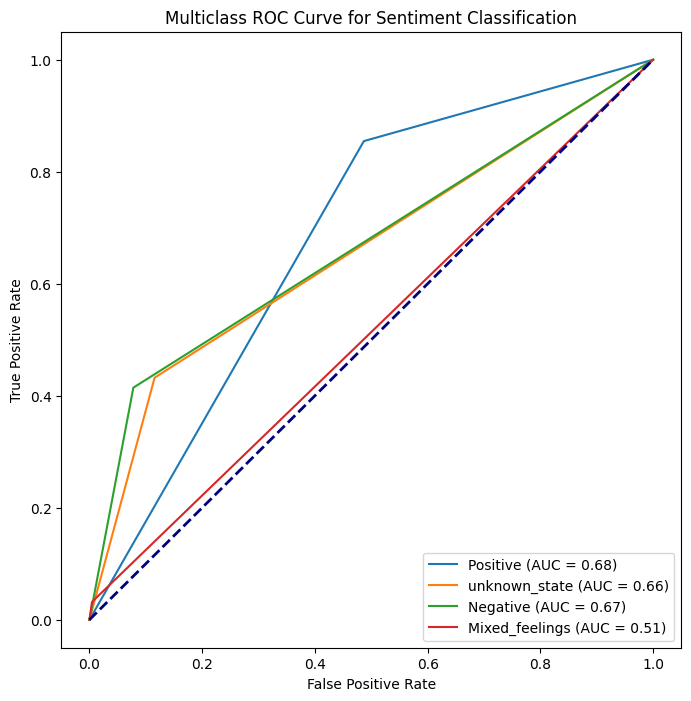

In [ ]:
# Assuming you have four labels
labels = ['Positive', 'unknown_state', 'Negative', 'Mixed_feelings']

# Calculate ROC-AUC score for each class
roc_auc_scores = []
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(try1["True_Labels"] == i, try1["Predicted_Labels"] == i)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(try1["True_Labels"] == i, try1["Predicted_Labels"] == i)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for Sentiment Classification')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# At some point, you decide to pause training and save the model's current state
model.save_weights("/content/drive/MyDrive/bert_model_saved_at_pause.ckpt")

In [ ]:
test_sentence = "இது ஒரு நல்ல படம். நான் அதை விரும்பினேன், மீண்டும் பார்க்கிறேன்"

predict_input = tokenizer.encode(test_sentence,

truncation=True,

padding=True,

return_tensors="tf")

tf_output = model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Positive','unknown_state','Negative','Mied_feelings']
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

1/1 [==============================] - 8s 8s/step
Positive


In [ ]:
checkpoint_path = "bert_training_checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=2
)

In [ ]:
# Later, when you want to resume training, load the saved model state
model.load_weights("/content/drive/MyDrive/bert_model_saved_at_pause.ckpt")

In [ ]:
# Train the model
history1 = model.fit(
    x={'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask},
    y=labels,
    epochs=3,
    batch_size=batch_size,
    validation_data=(
        {'input_ids': val_input_ids, 'token_type_ids': val_token_type_ids, 'attention_mask': val_attention_mask},
        val_labels.numpy()
    ),callbacks=[checkpoint_callback]
)

Epoch 1/3
5028/5028 [==============================] - ETA: 0s - loss: 0.7554 - accuracy: 0.7127
Epoch 1: val_loss improved from inf to 0.99737, saving model to bert_training_checkpoint.ckpt
5028/5028 [==============================] - 4163s 810ms/step - loss: 0.7554 - accuracy: 0.7127 - val_loss: 0.9974 - val_accuracy: 0.6429
Epoch 2/3
5028/5028 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.7489
Epoch 2: val_loss did not improve from 0.99737
5028/5028 [==============================] - 4054s 806ms/step - loss: 0.6672 - accuracy: 0.7489 - val_loss: 1.0838 - val_accuracy: 0.6170
Epoch 3/3
5028/5028 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.7815
Epoch 3: val_loss did not improve from 0.99737
5028/5028 [==============================] - 3993s 794ms/step - loss: 0.5891 - accuracy: 0.7815 - val_loss: 1.0495 - val_accuracy: 0.6239


In [ ]:
train_loss_history=[]
train_accuracy_history=[]
val_loss_history=[]
val_accuracy_history=[]
# Store metrics in lists
train_loss_history.extend(history1.history['loss'])
train_accuracy_history.extend(history1.history['accuracy'])
val_loss_history.extend(history1.history['val_loss'])
val_accuracy_history.extend(history1.history['val_accuracy'])

In [ ]:
print("train_loss_history : ",train_loss_history)
print("train_accuracy_history : ",train_accuracy_history)
print("val_loss_history : ",val_loss_history)
print("val_accuracy_history : ",val_accuracy_history)

train_loss_history :  [0.755359947681427, 0.6671936511993408, 0.5891369581222534]
train_accuracy_history :  [0.7126707434654236, 0.7489391565322876, 0.7814613580703735]
val_loss_history :  [0.9973688721656799, 1.0838232040405273, 1.0495234727859497]
val_accuracy_history :  [0.6428855657577515, 0.6170269250869751, 0.62392258644104]


In [ ]:
# At some point, you decide to pause training and save the model's current state
model.save_weights("/content/drive/MyDrive/bert_model_saved_at_pause1.ckpt")

In [ ]:
# Later, when you want to resume training, load the saved model state
model.load_weights("/content/drive/MyDrive/bert_model_saved_at_pause1.ckpt")

In [ ]:
# Train the model
history2 = model.fit(
    x={'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask},
    y=labels,
    epochs=2,
    batch_size=batch_size,
    validation_data=(
        {'input_ids': val_input_ids, 'token_type_ids': val_token_type_ids, 'attention_mask': val_attention_mask},
        val_labels.numpy()
    ),callbacks=[checkpoint_callback]
)

Epoch 1/2
5028/5028 [==============================] - ETA: 0s - loss: 0.5146 - accuracy: 0.8136
Epoch 1: val_loss improved from inf to 1.14065, saving model to bert_training_checkpoint.ckpt
5028/5028 [==============================] - 4354s 823ms/step - loss: 0.5146 - accuracy: 0.8136 - val_loss: 1.1407 - val_accuracy: 0.6439
Epoch 2/2
5028/5028 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.8360
Epoch 2: val_loss did not improve from 1.14065
5028/5028 [==============================] - 4122s 820ms/step - loss: 0.4512 - accuracy: 0.8360 - val_loss: 1.2575 - val_accuracy: 0.6234


In [ ]:
train_loss_history=[1.0303319692611694, 0.9533922076225281, 0.8949195146560669, 0.8296893835067749,0.755359947681427, 0.6671936511993408, 0.5891369581222534]
train_accuracy_history=[0.5978649854660034, 0.6214361786842346, 0.6492507457733154, 0.6773637533187866,0.7126707434654236, 0.7489391565322876, 0.7814613580703735]
val_loss_history=[0.9686756730079651, 0.9446980953216553, 0.9472882151603699, 0.9602656960487366,0.9973688721656799, 1.0838232040405273, 1.0495234727859497]
val_accuracy_history=[0.6192812919616699, 0.6276355981826782, 0.6374486088752747, 0.630287766456604,0.6428855657577515, 0.6170269250869751, 0.62392258644104]

In [ ]:
# Store metrics in lists
train_loss_history.extend(history2.history['loss'])
train_accuracy_history.extend(history2.history['accuracy'])
val_loss_history.extend(history2.history['val_loss'])
val_accuracy_history.extend(history2.history['val_accuracy'])

In [ ]:
print("train_loss_history : ",train_loss_history)
print("train_accuracy_history : ",train_accuracy_history)
print("val_loss_history : ",val_loss_history)
print("val_accuracy_history : ",val_accuracy_history)

train_loss_history :  [1.0303319692611694, 0.9533922076225281, 0.8949195146560669, 0.8296893835067749, 0.755359947681427, 0.6671936511993408, 0.5891369581222534, 0.5145832896232605, 0.4512036442756653]
train_accuracy_history :  [0.5978649854660034, 0.6214361786842346, 0.6492507457733154, 0.6773637533187866, 0.7126707434654236, 0.7489391565322876, 0.7814613580703735, 0.8135857582092285, 0.8360297083854675]
val_loss_history :  [0.9686756730079651, 0.9446980953216553, 0.9472882151603699, 0.9602656960487366, 0.9973688721656799, 1.0838232040405273, 1.0495234727859497, 1.1406540870666504, 1.2575371265411377]
val_accuracy_history :  [0.6192812919616699, 0.6276355981826782, 0.6374486088752747, 0.630287766456604, 0.6428855657577515, 0.6170269250869751, 0.62392258644104, 0.6439464092254639, 0.6233921051025391]


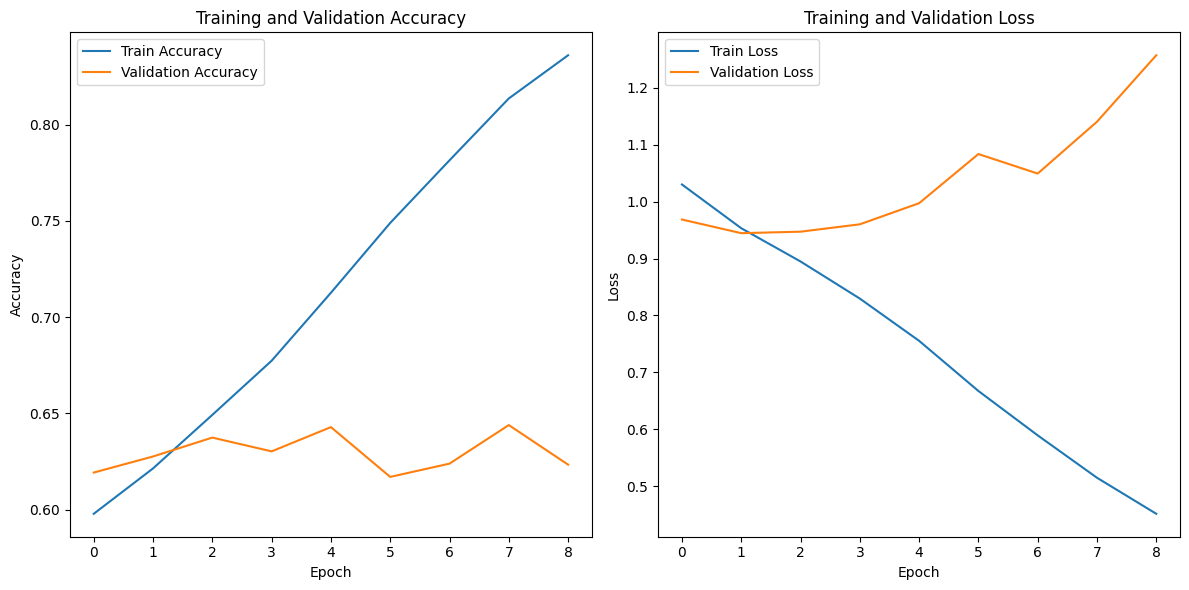

In [ ]:
#Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(
    x={'input_ids': val_input_ids, 'attention_mask': val_attention_mask}
)

236/236 [==============================] - 323s 1s/step


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,roc_auc_score

In [ ]:
# Convert predictions to labels
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convert one-hot encoded true labels to categorical labels
true_labels = np.argmax(val_labels.numpy(), axis=1)

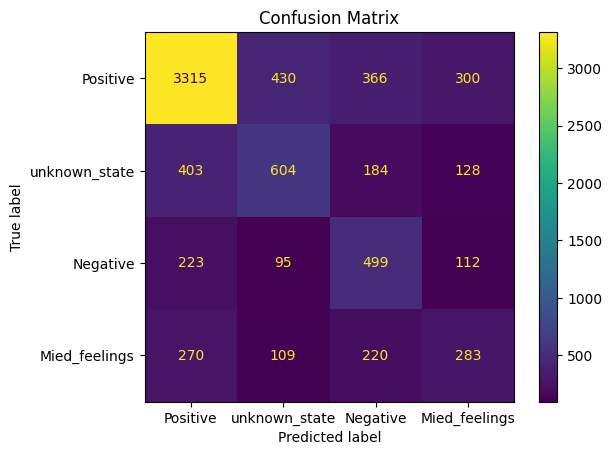

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Positive','unknown_state','Negative','Mied_feelings'])
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['Positive','unknown_state','Negative','Mied_feelings'])
print(class_report)

               precision    recall  f1-score   support

     Positive       0.79      0.75      0.77      4411
unknown_state       0.49      0.46      0.47      1319
     Negative       0.39      0.54      0.45       929
Mied_feelings       0.34      0.32      0.33       882

     accuracy                           0.62      7541
    macro avg       0.50      0.52      0.51      7541
 weighted avg       0.63      0.62      0.63      7541



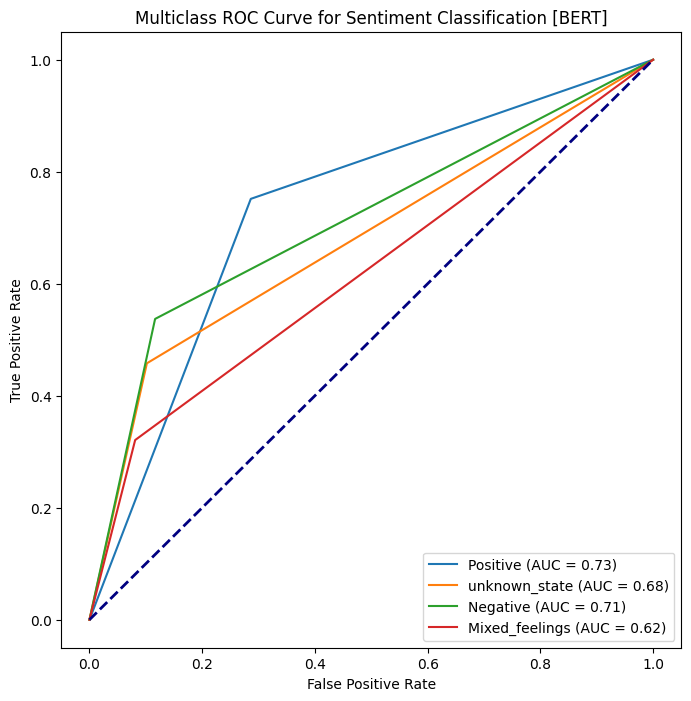

In [ ]:
# Assuming you have four labels
labels = ['Positive', 'unknown_state', 'Negative', 'Mixed_feelings']

# Calculate ROC-AUC score for each class
roc_auc_scores = []
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(true_labels == i,predicted_labels == i)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(true_labels == i,predicted_labels == i)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for Sentiment Classification [BERT]')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# At some point, you decide to pause training and save the model's current state
model.save_weights("content/drive/MyDrive/bert_model_saved_at_pause1.ckpt")